In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods101demi-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■
■ □ ■ $ ■ □ ■
■ □ ■ □ ■ □ ■
■ ■ □ ■ □ ■ ■
■ □ ■ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■
■ □ ■ □ ■ □ ■
■ ■ □ ■ □ ■ ■
■ A ■ □ ■ □ ■
■ □ ■ $ ■ □ ■
■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1min 19s, sys: 456 ms, total: 1min 19s
Wall time: 1min 23s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

1###0##0 4 None None 0###1##1         (empty)               q: 1.0   r: 683.8  ir: 0.0    f: 683.8  exp: 317 tga: 25    talp: 28826 tav: 1.04e+02 num: 1


10##9##0 4 None None 01##1##1         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 485 tga: 112   talp: 29050 tav: 46.6   num: 1


10#0###0 1 None None 01#1###1         (##1#101#)            q: 0.36  r: 914.6  ir: 0.0    f: 329.5  exp: 414 tga: 114   talp: 29022 tav: 20.5   num: 1


01#1###1 5 None None 10#0###0         (##1#111#)            q: 0.967 r: 616.7  ir: 0.0    f: 596.3  exp: 177 tga: 118   talp: 29013 tav: 1.7e+02 num: 1


01#1#0#1 5 None None 10#0###0         (empty)               q: 1.0   r: 580.1  ir: 0.0    f: 580.1  exp: 104 tga: 118   talp: 29013 tav: 2.77e+02 num: 1


0###10## 0 None None 1###01##         (empty)               q: 1.0   r: 568.4  ir: 0.0    f: 568.4  exp: 210 tga: 124   talp: 28974 tav: 1.35e+02 num: 1


01###1#1 3 None None 10###0#0         (##111#1#)            q: 0.941 r: 593

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population()
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 13.6 s, sys: 140 ms, total: 13.8 s
Wall time: 14.6 s


### Performance

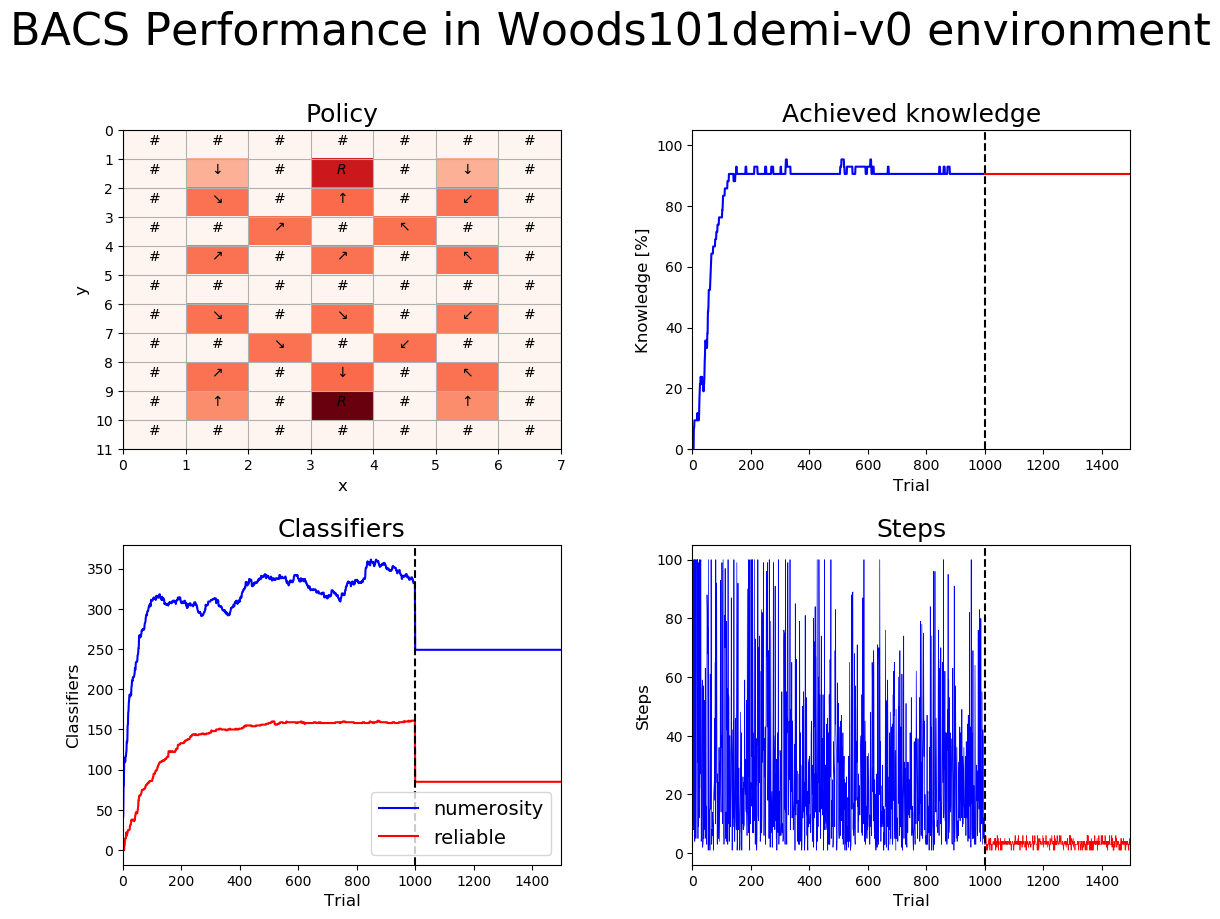

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  29.051  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  3.394  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit if cl.does_anticipate_change()]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

10##9##0 4 None None 01##1##1         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 485 tga: 112   talp: 29050 tav: 46.6   num: 1


9##010## 0 None None 1##101##         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 472 tga: 173   talp: 29047 tav: 57.4   num: 1


10#111#0 1 [7] [('1', '0', '1', '0', '1', '0', '1', '0')] 91#0#0#1         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 286 tga: 1246  talp: 28966 tav: 1.41e+02 num: 1


#0#101#1 1 [3] [('1', '0', '1', '0', '1', '0', '1', '0')] ####9##0         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 256 tga: 2258  talp: 28837 tav: 1.11e+02 num: 1


11#010#1 3 [5] [('1', '0', '1', '0', '1', '0', '1', '0')] #0#191#0         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 268 tga: 2090  talp: 29033 tav: 84.7   num: 1


#1#101#0 7 [5] [('1', '0', '1', '0', '1', '0', '1', '0')] #0##9###         (empty)               q: 1.0   r: 950.0  ir: 